# 1. Install and imports

In [ ]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git
import nltk
nltk.download('stopwords')

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-969t_4bc
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-969t_4bc
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=4d8752ccc83184f865b6ddc7252b6877d869624654094ce1fab0072644854876
  Stored in directory: /tmp/pip-ephem-wheel-cache-dsy_p0e2/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from keras_contrib.layers import CRF

In [ ]:
import cross_validator as cross_validator
import datahandler as datahandler
from datamodel import DataModel
import outputmaker as outputmaker
import metrics as metrics

trial = datahandler.load_train('tsd_trial.csv', verbose=True)
train = datahandler.load_train('tsd_train.csv', verbose=True)

,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th..."


,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."


# 2.Load

In [ ]:
datamodel = DataModel(model='crf', remove_stop_words=False)

output_maker = outputmaker.crf_output

evaluator = metrics

In [ ]:
X_train, y_train, train_taboo_words, train_texts = cross_validator.load_data(train, [i for i in range(train.shape[0])],
                                                                             datamodel, logger=True)

X_test, y_test, test_taboo_words, test_texts = cross_validator.load_data(trial, [i for i in range(trial.shape[0])], 
                                                                   datamodel, logger=True)

100%|██████████| 690/690 [00:30<00:00, 22.53it/s]


In [ ]:
X_test[0]

[('Because', 'IN', 'normal', [0, 1, 2, 3, 4, 5, 6]),
 ('he', 'PRP', 'normal', [8, 9]),
 ('a', 'DT', 'normal', [13]),
 ('moron', 'NN', 'toxic', [15, 16, 17, 18, 19]),
 ('and', 'CC', 'normal', [21, 22, 23]),
 ('a', 'DT', 'normal', [25]),
 ('bigot', 'NNP', 'toxic', [27, 28, 29, 30, 31]),
 ('It', 'PRP', 'normal', [34, 35]),
 ('not', 'RB', 'normal', [39, 40, 41]),
 ('any', 'DT', 'normal', [43, 44, 45]),
 ('more', 'RBR', 'normal', [47, 48, 49, 50]),
 ('complicated', 'JJ', 'normal', [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 ('than', 'IN', 'normal', [64, 65, 66, 67]),
 ('that', 'DT', 'normal', [69, 70, 71, 72])]

# 3. Preprocessing


In [ ]:
from tqdm import tqdm 
#from nltk.stem.porter import *
#stemmer = PorterStemmer()


special_chars = ['O', '4', '͞', 'ü', '😞', '»', '”', '\x7f', '"', '7', '*', '8', ')',
      '😂', '💀', '{', '0', 'ʻ', '💨', '•', '#', '_', '😊', '😜', 'ó', '😅', 
      '¬', '☠', '🙄', '😉', '😆', '―','(', '.', '?', '😵', '💥', ':', '🆘',
      '$', '=', '+', ';', '🔥', '😁','`', 'ï', '2', 'ê', 'é', '3', '-', '🤥',
      '⚽', 'É', '️', '!', '5', '✭', '9', '😈', 'ˈ', '😬', '@', '«', '/', '▀', '’',
      '😡', '1', '%', ',', '&', '6', '\\', ']', "'", '[', '^', '}', '⚾', '\u200b',
       '☭', '☹', '<', 'l', '™', '👎']


F_cleaner = lambda x: ''.join([w for w in x if w not in special_chars ]).lower()

     
def cleaning(X):
    cleaned_x = []
    for words in tqdm(X):
        cleaned_words = []
        for word in words :
            w, pos, tag, span = word
            cleaned_w = F_cleaner(w)
            if len(cleaned_w) != 0:
                cleaned_words.append((cleaned_w, pos, tag, span))
                #cleaned_words.append((stemmer.stem(cleaned_w), pos, tag) )
        cleaned_x.append(cleaned_words)
    return cleaned_x

In [ ]:
X_train = cleaning(X_train)
X_test_clean = cleaning(X_test)

100%|██████████| 690/690 [00:00<00:00, 1840.47it/s]


# 4. Preprations for modeling

In [ ]:
words = set([w for x in X_train + X_test_clean for w, tag, label, span in x])
tags = set([tag for x in X_train for w, pos, tag, span in x])

n_tags = len(tags)
n_words = len(words)

print("n_tags:{}, n_words:{}\n".format(n_tags, n_words))

max_len = max([len(x) for x in X_train+X_test_clean])
print("max_len:{} ".format(max_len))

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

print("word2idx['fuck']:{},  tag2idx['normal']:{}\n".format(word2idx["fuck"], tag2idx["normal"]))

n_tags:2, n_words:19666

max_len:191 
word2idx['fuck']:12943,  tag2idx['normal']:1



In [ ]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils import to_categorical

X_word = [[word2idx[w[0]] for w in s] for s in tqdm(X_train)]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, 
                       value=word2idx["PAD"], padding='post', truncating='post')


y_ = [[tag2idx[w[2]] for w in s] for s in X_train]

print("len(y):, ", len(y_))

y_ = pad_sequences(maxlen=max_len, sequences=y_, 
                  value=tag2idx["PAD"], padding='post', truncating='post')

y = [to_categorical(i, num_classes=n_tags+1) for i in y_]

100%|██████████| 7939/7939 [00:00<00:00, 114843.28it/s]


len(y):,  7939


In [ ]:
X_word_tr, y_tr = X_word, y

# 4.5 Attention

In [ ]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

# 5. Modeling

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, GRU
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.metrics import classification_report

from keras_contrib.layers import CRF
import keras
print("Keras:", keras.__version__)
import tensorflow
print("tf:",tensorflow.__version__)


Keras: 2.4.3
tf: 2.4.0


In [ ]:
import tensorflow_addons as tfa

In [ ]:
def frobenius_norm(m):
    """This function is to calculate the frobenius norm of the matrix of all
    layer's weight.
  
    Args:
        m: is a list of weights param for each layers.
    """
    total_reduce_sum = 0
    for i in range(len(m)):
        total_reduce_sum = total_reduce_sum + tf.math.reduce_sum(m[i]**2)
    norm = total_reduce_sum**0.5
    return norm

In [ ]:

CG_frobenius_norm_of_weight = []
CG_get_weight_norm = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda batch, logs: CG_frobenius_norm_of_weight.append(
        frobenius_norm(model_1.trainable_weights).numpy()))

In [ ]:
# input and embedding for words
word_in = Input(shape=(max_len,))

emb_word = Embedding(input_dim=n_words + 2, output_dim=50,
                     input_length=max_len, mask_zero=True)(word_in)

x = Bidirectional(GRU(units=50, return_sequences=True,
                               recurrent_dropout=0.4))(emb_word)
#x = Bidirectional(LSTM(units=50, return_sequences=True,
#                               recurrent_dropout=0.4))(emb_word)

#x = TimeDistributed(Attention(max_len))(x)
#x = TimeDistributed(Dense(100, activation="relu"))(x)

out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(x)

#out = TimeDistributed(Dense(50, activation="tanh"))(x)  # a dense layer as suggested by neuralNer

#crf = CRF(n_tags + 1)  # CRF layer, n_tags+1(PAD)
#out = crf(x)  # output

model = Model(word_in, out)
model.compile(optimizer=tfa.optimizers.ConditionalGradient(
        learning_rate=0.99949, lambda_=203), 
        loss='sparse_categorical_crossentropy',  metrics=['accuracy'])
#"sparse_categorical_crossentropy"
              

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 191)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 191, 50)           983400    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 191, 100)          30600     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 191, 3)            303       
Total params: 1,014,303
Trainable params: 1,014,303
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_word_tr, np.array(y_), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/10
224/224 [==============================] - 281s 1s/step - loss: 0.0653 - accuracy: 0.9056 - val_loss: 0.0393 - val_accuracy: 0.9416
Epoch 2/10
224/224 [==============================] - 278s 1s/step - loss: 0.0436 - accuracy: 0.9313 - val_loss: 0.0373 - val_accuracy: 0.9419
Epoch 3/10
224/224 [==============================] - 277s 1s/step - loss: 0.0429 - accuracy: 0.9338 - val_loss: 0.0382 - val_accuracy: 0.9415
Epoch 4/10
224/224 [==============================] - 282s 1s/step - loss: 0.0413 - accuracy: 0.9331 - val_loss: 0.0363 - val_accuracy: 0.9434
Epoch 5/10
224/224 [==============================] - 279s 1s/step - loss: 0.0403 - accuracy: 0.9353 - val_loss: 0.0356 - val_accuracy: 0.9430
Epoch 6/10
224/224 [==============================] - 289s 1s/step - loss: 0.0370 - accuracy: 0.9362 - val_loss: 0.0365 - val_accuracy: 0.9428
Epoch 7/10
224/224 [==============================] - 290s 1s/step - loss: 0.0353 - accuracy: 0.9382 - val_loss: 0.0363 - val_accuracy: 0.9431

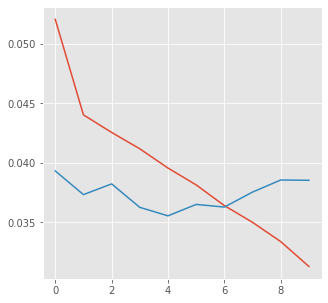

In [ ]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(5,5))
#plt.plot(hist["acc"])
#plt.plot(hist["val_acc"])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()


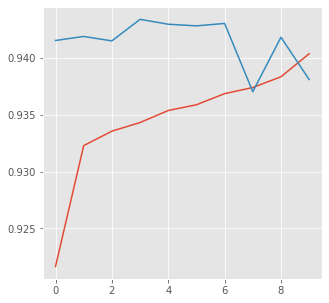

In [ ]:

plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

plt.show()

In [ ]:
X_test_clean[0]

[('because', 'IN', 'normal', [0, 1, 2, 3, 4, 5, 6]),
 ('he', 'PRP', 'normal', [8, 9]),
 ('a', 'DT', 'normal', [13]),
 ('moron', 'NN', 'toxic', [15, 16, 17, 18, 19]),
 ('and', 'CC', 'normal', [21, 22, 23]),
 ('a', 'DT', 'normal', [25]),
 ('bigot', 'NNP', 'toxic', [27, 28, 29, 30, 31]),
 ('it', 'PRP', 'normal', [34, 35]),
 ('not', 'RB', 'normal', [39, 40, 41]),
 ('any', 'DT', 'normal', [43, 44, 45]),
 ('more', 'RBR', 'normal', [47, 48, 49, 50]),
 ('compicated', 'JJ', 'normal', [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 ('than', 'IN', 'normal', [64, 65, 66, 67]),
 ('that', 'DT', 'normal', [69, 70, 71, 72])]

In [ ]:
X_word_test = []
no = []
for s in X_test_clean:
    x_s = []
    for w in s:
        try:
            x_s.append(word2idx[w[0]])
        except:
            no.append(w)
    X_word_test.append(x_s)

X_word_test = [[word2idx[w[0]] if w[0] in word2idx else word2idx["UNK"] for w in s] for s in tqdm(X_test_clean)]

print("not in word2idx:{}, length of X_word_test:{}".format(len(no), len(X_word_test)))

X_word_test = pad_sequences(maxlen=max_len, sequences=X_word_test, 
                            value=word2idx["PAD"], padding='post', truncating='post')

100%|██████████| 690/690 [00:00<00:00, 72986.73it/s]

not in word2idx:0, length of X_word_test:690


In [ ]:
y_pred_test = model.predict(X_word_test)

In [ ]:
y_test_preds, probas = [], []
for i in tqdm(range(y_pred_test.shape[0])):
    p = np.argmax(y_pred_test[i], axis=-1)
    preds, proba = [],[]
    lenght = 0
    for w, pred in zip(X_word_test[i], p):
        if w != 0:
            preds.append(idx2tag[pred])
            lenght+=1
    y_test_preds.append(preds)
    probas.append(y_pred_test[i][:lenght])

print("predicted test size:", len(y_test_preds))

predictions = output_maker(X_test, test_texts, y_test_preds)

f1, p, r = evaluator.evaluate(gold = y_test, predictions = predictions)

print("F1:{}, \t P:{}, \t R:{}".format(f1, p, r))

100%|██████████| 690/690 [00:00<00:00, 2668.66it/s]

predicted test size: 690
F1:0.6253375069018557, 	 P:0.7107548096216852, 	 R:0.6422807436447145


In [ ]:
ids = [ i for i in range(len(predictions))]

with open("spans-pred.txt", "w") as out:
    for uid, text_scores in zip(ids, predictions):
        out.write(f"{str(uid)}\t{str(text_scores)}\n")

In [ ]:
https://www.kaggle.com/hamedbabaeigiglou/thesiswork-word-and-char-based-bi-lstm#3.-Preprocessing

https://github.com/BrambleXu/aspect-term-extraction/blob/master/notebooks/bi-lstm-crf-embedding.ipynb